In [1]:
# %% [Cell 1] Imports and Configuration
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50

# Hyperparameters and Configuration

SCRIPT_DIR = os.getcwd()
WEIGHTS_DIR = os.path.join(SCRIPT_DIR, "float_model")
LOG_DIR = os.path.join(SCRIPT_DIR, "logs")

DATASET_DIR = os.path.join(SCRIPT_DIR, "grocery_store_dataset")
TRAIN_DIR = os.path.join(DATASET_DIR, "new/train")
VALID_DIR = os.path.join(DATASET_DIR, "new/valid")
TEST_DIR = os.path.join(DATASET_DIR, "new/test")

NUM_CLASSES = 8
NUM_EPOCHS = 100
INIT_LR = 0.001
BATCH_SIZE = 16

# Ensure directories exist
os.makedirs(WEIGHTS_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# Define label names (update this based on your dataset)
labelNames_list = ["Apple", "Juice", "Melon", "Milk", "Pear", "Pepper", "Tomato", "Yoghurt"]
labelNames_dict = {name: i for i, name in enumerate(labelNames_list)}

In [2]:
# %% [Cell 2] Data Loading and Preprocessing
def load_data(directory):
    img_list = [os.path.join(root, name)
                for root, _, files in os.walk(directory)
                for name in files
                if name.endswith((".jpg", ".jpeg", ".png"))]
    np.random.shuffle(img_list)
    x, y = list(), list()
    for img_path in img_list:
        classname = os.path.basename(os.path.dirname(img_path))
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # ResNet50 expects 224x224 images
        x.append(img)
        y.append(labelNames_dict[classname])
    return np.array(x), np.array(y)

x_train, y_train = load_data(TRAIN_DIR)
x_valid, y_valid = load_data(VALID_DIR)
x_test, y_test = load_data(TEST_DIR)

print(f"x_train.shape: {x_train.shape}")
print(f"x_valid.shape: {x_valid.shape}")
print(f"x_test.shape: {x_test.shape}")

# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_valid = to_categorical(y_valid, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# Normalize images
x_train = x_train.astype('float32') / 255
x_valid = x_valid.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train.shape: (1464, 224, 224, 3)
x_valid.shape: (176, 224, 224, 3)
x_test.shape: (176, 224, 224, 3)


In [3]:

# %% [Cell 3] Model Definition
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
output = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=INIT_LR), metrics=["accuracy"])
model.summary()

# Plot model architecture
model_filename = os.path.join(LOG_DIR, "train_resnet50_grocery_model.png")
plot_model(model, to_file=model_filename, show_shapes=True)


Output hidden; open in https://colab.research.google.com to view.

In [5]:
# %% [Cell 4] Model Training
# Set up callbacks
fname = os.path.join(WEIGHTS_DIR, "train_resnet50_grocery_best_chkpt.h5")
checkpoint = ModelCheckpoint(
    filepath=fname,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

# callbacks_list = [checkpoint, early_stopping_callback]
callbacks_list = [checkpoint]

# Train the model
startTime = datetime.now()
H = model.fit(
    x_train,
    y_train,
    steps_per_epoch=len(x_train)//BATCH_SIZE,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_valid, y_valid),
    validation_steps=len(x_valid)//BATCH_SIZE,
    callbacks=callbacks_list,
    shuffle=True,
)
endTime = datetime.now()
diff = endTime - startTime
print(f"\nElapsed time for Keras training (s): {diff.total_seconds()}\n")

# Save the final model
fname_final = os.path.join(WEIGHTS_DIR, "train_resnet50_grocery_final.h5")
model.save(fname_final)


Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9844
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to /content/grocery_store/float_model/train_resnet50_grocery_best_chkpt.h5
22/22 [==============================] - 19s 877ms/step - loss: 0.0515 - accuracy: 0.9844 - val_loss: 20.5183 - val_accuracy: 0.1250
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9864
Epoch 2: val_accuracy did not improve from 0.12500
22/22 [==============================] - 15s 671ms/step - loss: 0.0511 - accuracy: 0.9864 - val_loss: 7.6084 - val_accuracy: 0.1250
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9900
Epoch 3: val_accuracy did not improve from 0.12500
22/22 [==============================] - 15s 666ms/step - loss: 0.0277 - accuracy: 0.9900 - val_loss: 6.5949 - val_accuracy: 0.1172
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.2403

In [7]:
# %% [Cell 5] Model Evaluation with Best Checkpoint
from tensorflow.keras.models import load_model

# Load the best checkpoint model
best_model_path = os.path.join(WEIGHTS_DIR, "train_resnet50_grocery_best_chkpt.h5")
best_model = load_model(best_model_path)

print("\n[INFO] evaluating network on Test and Validation datasets using the best checkpoint model...\n")

# Evaluate on validation set
scores_valid = best_model.evaluate(x_valid, y_valid, batch_size=BATCH_SIZE)
print(f'Validation Loss: {scores_valid[0]:.3f}')
print(f'Validation Accuracy: {scores_valid[1]:.3f}')

# Evaluate on test set
scores_test = best_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(f'Test Loss: {scores_test[0]:.3f}')
print(f'Test Accuracy: {scores_test[1]:.3f}')

# Make predictions and print classification report
preds = best_model.predict(x_test)
print(classification_report(
    y_test.argmax(axis=1),
    preds.argmax(axis=1),
    target_names=labelNames_list
))


[INFO] evaluating network on Test and Validation datasets using the best checkpoint model...

3/3 [==============================] - 4s 2s/step - loss: 0.0854 - accuracy: 0.9716
Validation Loss: 0.085
Validation Accuracy: 0.972
3/3 [==============================] - 1s 163ms/step - loss: 0.1119 - accuracy: 0.9716
Test Loss: 0.112
Test Accuracy: 0.972
6/6 [==============================] - 5s 401ms/step
              precision    recall  f1-score   support

       Apple       1.00      0.86      0.93        22
       Juice       0.96      1.00      0.98        22
       Melon       1.00      1.00      1.00        22
        Milk       0.96      1.00      0.98        22
        Pear       0.88      1.00      0.94        22
      Pepper       1.00      0.95      0.98        22
      Tomato       1.00      1.00      1.00        22
     Yoghurt       1.00      0.95      0.98        22

    accuracy                           0.97       176
   macro avg       0.97      0.97      0.97       1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


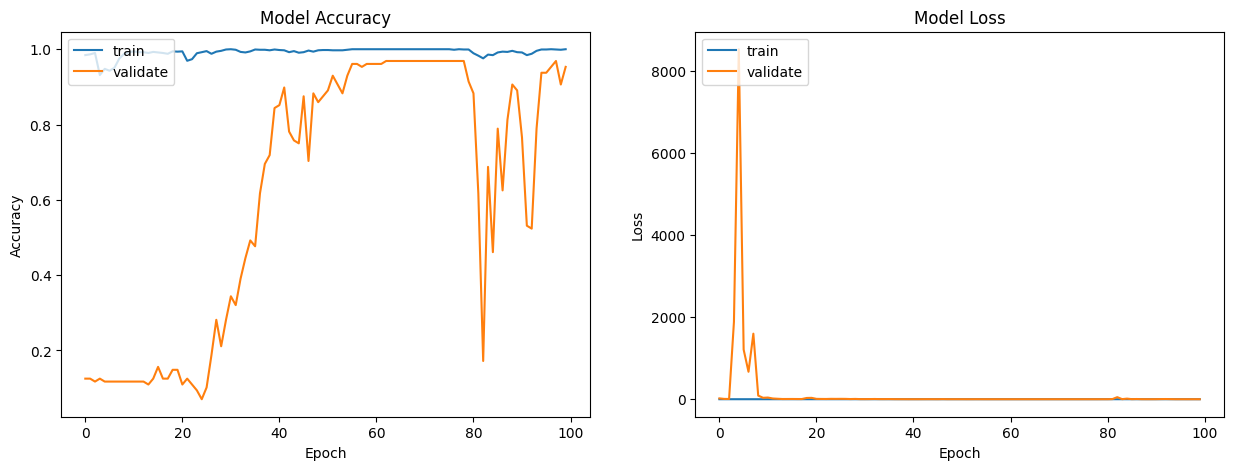

<Figure size 640x480 with 0 Axes>

In [8]:
# %% [Cell 6] Visualize Training History
def plotmodelhistory(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(history.history["accuracy"])
    axs[0].plot(history.history["val_accuracy"])
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(["train", "validate"], loc="upper left")

    axs[1].plot(history.history["loss"])
    axs[1].plot(history.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(["train", "validate"], loc="upper left")
    plt.show()

print(H.history.keys())
plotmodelhistory(H)

plot_filename = os.path.join(LOG_DIR, "train_resnet50_grocery_history.png")
plt.savefig(plot_filename)
plt.show()